# Connect and authorize google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

In [ ]:
# %cd /content/gdrive/My Drive/
%cd /content/gdrive/My Drive/Colab Notebooks/ML_HI/tano_signal/
!ls

In [ ]:
! pwd

# Install

In [ ]:
! pip install spectral_cube

# Libraries

In [ ]:
import sys
import os
import copy

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from pathlib import Path

from astropy.io  import fits
from astropy        import units as u
from astropy.wcs import WCS


import importlib

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

from spectral_cube import SpectralCube

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# GPU or CPU

In [ ]:
# GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)
print('device_count: ', torch.cuda.device_count())

device:  cpu
device_count:  0


# Paths

In [ ]:
base_path = Path('/content/gdrive/MyDrive/Colab Notebooks/ML_HI/')

tano_signal_path = base_path / 'tano_signal' / 'tano_signal'
checkpoint_path  = tano_signal_path / 'checkpoints'

data_path = base_path / 'data'

tanosignal_path  = base_path / 'tano_signal'
tanosignal_pred_path = tanosignal_path / 'pred'

saury2014_data_path = data_path / 'saury'
seta_data_path = data_path / 'seta'

print('Saury 2014: ', saury2014_data_path)

# Utils

In [ ]:
def read_fits_cube(filename):
    """
    Read

    Parameters
    ----------
    filename (string) : filename of FITS file
    Input data.

    Returns
    -------
    cube
    WCS
    X-coordinates
    Y-coordinates
    Velocity

    Other parameters
    ----------------
    None
    """

    # Read FITS file
    dat = fits.open(filename)  # Open the FITS file for reading
    c = SpectralCube.read(dat)  # Initiate a SpectralCube

    # Parse the WCS keywords in the primary HDU
    hdr = dat[0].header
    # w = WCS(hdr)

    w = WCS(naxis=2)
    w.wcs.crpix = [hdr['CRPIX1'], hdr['CRPIX2']]
    w.wcs.cdelt = np.array([hdr['CDELT1'], hdr['CDELT2']])
    w.wcs.crval = [hdr['CRVAL1'], hdr['CRVAL2']]
    w.wcs.ctype = [hdr['CTYPE1'], hdr['CTYPE2']]


    dat.close()  # Close the FITS file - we already read it in and don't need it anymore!

    print(f"Cube shape: {c.shape}") # (vlsr, b, l) : (971, 201, 376)

    del dat
    # cube = cube.with_spectral_unit(u.km / u.s)

    _, _, x = c.world[0, 0, :]      # extract RA: deg
    _, y, _ = c.world[0, :, 0]      # extract DEC:  deg
    v, _, _ = c.world[:, 0, 0]      # extract velocity

    return c, w, x, y, v, hdr

In [ ]:
def get_val_pix(datmap, x, y, w):
    # Convert world coordinates to pixel coordinates
    xpix, ypix = w.world_to_pixel_values(x, y)

    # Round pixel coordinates to nearest integer
    xpix = [int(round(xi)) for xi in xpix]
    ypix = [int(round(yi)) for yi in ypix]

    # Access data array using the computed pixel coordinates
    value = datmap[ypix, xpix]

    return value, xpix, ypix

In [ ]:
def plott_(im, title, label):
    plt.figure(figsize=(10,10))
    plt.imshow(im, cmap='cividis')
    cbar = plt.colorbar(shrink=0.5, pad=0.005)
    cbar.set_label(f'${label}$', size=16)
    plt.title(f'{title}')
    plt.gca().invert_yaxis()
    plt.xlabel('X [Coordinate]')
    plt.ylabel('Y [Coordinate]')
    plt.show()

# Preprocessing

In [ ]:

"""
@author: Haiyang.Tang
Do not used for commercial purpose!
"""

"""
    ToDict: A class of dictionary maker.
    generate a dictionary for the datacube that conatins ground truth.
    Used for 101 velocity channels data (data with 101 length).

    initialization Attributes
    ----------
    cube: data cube
        spectral data cube.
    Rhi: cube
        Ground-truth RHI
    Fcnm:  cube
        Ground-truth FCNM

    Methods
    -------
    make_dict_gt:
        generate a dictionary for the datacube that contains ground truth.
        it can be used for training and prediction.

    make_dict:
        generate a dictionary for observed datacube
        it can be used for prediction only.

"""


class Prep:
    def __init__(self):
        print('Data preprocessing ...')

    def fit(self, cube, fcnm=None, rhi=None):
        nchan, nrow, ncol = cube.shape
        num = nrow * ncol

        print('Data cube shape: ', nchan, nrow, ncol)
        recube = cube.reshape(nchan, -1, order='C')
        print('Reshaped cube: ', recube.shape)

        if (rhi is None) or (fcnm is None):
            print('Prediction mode ...')
            return recube

        if (rhi is not None) and (fcnm is not None):
            print('Training mode ...')
            return recube, fcnm.reshape(num, order='C'), rhi.reshape(num, order='C')

        return None

In [ ]:

"""
@author: Haiyang.Tang
Do not used for commercial purpose!
"""

"""
    ToDict: A class of dictionary maker.
    generate a dictionary for the datacube that conatins ground truth.
    Used for 101 velocity channels data (data with 101 length).

    initialization Attributes
    ----------
    cube: data cube
        spectral data cube.
    Rhi: cube
        Ground-truth RHI
    Fcnm:  cube
        Ground-truth FCNM

    Methods
    -------
    make_dict_gt:
        generate a dictionary for the datacube that contains ground truth.
        it can be used for training and prediction.

    make_dict:
        generate a dictionary for observed datacube
        it can be used for prediction only.

"""


class ToDict:
    '''
    This is not a good way to store data!
    Because loading a big dataset to a dictionary consumes resources
    We will change this in future.
    '''

    def __init__(self, cube ,rhi, fcnm):
        self.rhi  = rhi
        self.fcnm = fcnm
        self.cube = cube

        self.num_channel, self.num_row, self.num_column = cube.shape
        self.num = self.num_row * self.num_column

    def make_dict_gt(self):
        '''
        Dictionary for ground-truth data
        '''
        if (self.rhi is None) or (self.fcnm is None):
            print("No ground truth data! Please use method make_dict.!")
            return None

        ret = {}
        for i in range(0, self.num):
            idx = i
            rid = idx//self.num_column
            cid = idx%self.num_column
            ret[i] = (self.cube[:, rid, cid], [rid, cid], [self.fcnm[rid, cid], self.rhi[rid, cid]] )

        print('Dictionary generated successfully! Dictionary structure : [key : (spectra , coordinates , [fcnm, rhi])]')
        return ret

    def make_dict(self):
        '''
        Dictionary for observed data
        '''
        ret = {}
        for i in range(0, self.num):
            idx = i
            rid = idx//self.num_column
            cid = idx%self.num_column
            ret[i] = (self.cube[:,rid, cid], [rid, cid])

        print('Dictionary generated successfully! Dictionary structure: [key : (spectra , coordinates)]')
        return ret


# Models

In [ ]:

# -*- coding: utf-8 -*-
"""
@author: Haiyang.Tang
Do not used for commercial purpose!
"""


#Transformer Positional Encoder


"""
    PositionalEncoding: positional encoding method in original natural language processing.

    Methods
    -------
    forward(x):
        add positional encoding to x and return x.
"""


class PE(nn.Module):
    # custom code
    def __init__(self, num_features, sequence_len=6, d_model=9):
        super(PE, self).__init__()

        pe     = torch.zeros((1, sequence_len, d_model), dtype=torch.float32)
        factor = -math.log(10000.) / d_model  # outs loop

        for index in range(0, sequence_len):  # position of word in seq
            for i in range(0, d_model, 2):
                div_term = math.exp(i * factor)
                pe[0, index, i] = math.sin(index * div_term)
                if (i+1 < d_model):
                    pe[0, index, i+1] = math.cos(index * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        # x has shape [seq_len, bat_size, embed_dim]
        x = x + self.pe[:x.size(0), :]
        return x

In [ ]:
class Models(nn.Module):
    def __init__(self, pev, num_output, input_column, dropout, device):
        super(Models, self).__init__()
        self.pev = pev

        in_channels = 1
        input_row = 2 # index_c, sin_c, poly_c: 2

        self.num_output   = num_output
        self.in_channels  = 1
        self.input_column = input_column
        self.dropout      = dropout
        self.device       = device

        self.get_input_row() # input_row
        self.get_lpe()
        self.get_pe()



    def get_lpe(self):
        if self.pev == 'learnable_PEV':
            self.lpe = True
        else:
          self.lpe = False

    def get_input_row(self):
        if self.pev in ['index_concate', 'sin_concate', 'poly_concate']:
            self.input_row = 2
        else:
            self.input_row = 1






    def load_weights(self, checkpoint_path):
        """
        Load check point

        Parameters:


        Returns:
         -
        """

        print('Checkpoint file: ', checkpoint_path)

        try:
            if checkpoint_path.is_file():
                checkpoint = torch.load(checkpoint_path, map_location=self.device)
                self.load_state_dict(checkpoint['net'])
                self.to(self.device)
                self.eval()

                print('sucessfully load the weights!')
            else:
                print("The file does not exist.")
                print(checkpoint_path)
        except Exception as e:
            print("An error occurred while reading the file:", e)



    # Calc. output size
    def get_output_size(self, Hin, Win, k = [3, 3], s = [1, 1], p = [0, 0], d = [1, 1]):
        return int((Hin + 2*p[0] - d[0]*(k[0] - 1)/s[0] - 1) + 1), int((Win + 2*p[1] - d[1]*(k[1] - 1)/s[1] - 1) + 1)


    def pe_index_concate(self, spec):
        pos  = np.linspace(0, 1., self.input_column).reshape(1, -1)
        spec = np.vstack((spec, pos))
        spec = spec.reshape(1, 2, self.input_column)
        return spec

    def pe_index_add(self, spec):
        pos   = np.linspace(0, 1., self.input_column).reshape(1, -1)
        spec  = spec + pos
        spec  = spec.reshape(1, 1, self.input_column)
        return spec

    def pe_sin_add(self, spec):
        pos  = np.sin(np.linspace(0, 1., self.input_column).reshape(1, -1))
        spec = spec + pos
        spec = spec.reshape(1, 1, self.input_column)
        return spec

    def pe_sin_concate(self, spec):
        pos  = np.sin(np.linspace(0, 1., self.input_column).reshape(1, -1))
        spec = np.vstack((spec, pos))
        spec = spec.reshape(1, 2, self.input_column)
        return spec

    def pe_poly_concate(self, spec):
        spec = np.vstack((spec, spec**2))
        spec = spec.reshape(1, 2, self.input_column)
        return spec


    def pe_original_vector(self, spec):
        return spec.reshape(1, 1, self.input_column)


    def get_pe(self):
        pes = {
            'index_concate'   : self.pe_index_concate,
            'index_add'       : self.pe_index_add,
            'sin_concate'     : self.pe_sin_concate,
            'sin_add'         : self.pe_sin_add,
            'poly_concate'    : self.pe_poly_concate,
            'original_vector' : self.pe_original_vector,
            'learnable_PEV'   : self.pe_original_vector
        }

        print('Positional Encoding: ', self.pev)

        self.pe_fcn = pes.get(self.pev, None)


    def predict(self, cube):
        nchan, nrow, ncol = cube.shape
        ntotal = nrow * ncol
        dat = Prep().fit(cube, fcnm=None, rhi=None)

        fcnm = np.zeros(ntotal)
        rhi  = np.zeros(ntotal)
        with torch.no_grad():
            for i in range(ntotal):
                if i%1e4 == 0:
                  print(i, '/', ntotal)

                spec = dat[:nchan, i]

                spec = self.pe_fcn(spec)
                spec = spec.reshape(1, spec.shape[0], spec.shape[1], -1).astype(np.float32)
                spec = torch.from_numpy(spec)
                spec = spec.to(self.device)

                # Feed single spectrum (+pe)
                pred = self(spec)

                fcnm[i] = pred[0][0].cpu().detach().numpy()
                rhi[i]  = pred[0][1].cpu().detach().numpy()
            # End - for
        # End - with

        fcnm = fcnm.reshape(nrow, ncol, order='C')
        rhi  = rhi.reshape(nrow, ncol, order='C')

        print('Complete !')
        return fcnm, rhi



In [ ]:
"""
    cnn_transformer_small: A class of the CNN_transformer small model.

    input Attributes
    ----------
    num_features : int
        The number of features.
    drop_rate : the drop out rate in transformer.
        input channel number.
    pos_encoder : PositionalEncoding.
        original positional encoder in NLP.
    lpe: boolean
        whether or not add leanable positional embedding to transformer inputs.
    pos_embedding: nn.Parameter(.)
        learnable parameters for positional embedding.

    Methods
    -------
    forward(x):
        calculate the outputs.

"""
class CNN_Transformer(Models):
    def __init__(self, pev, num_output, input_column, dropout, device):
        super().__init__(pev, num_output, input_column, dropout, device)

        p = [0, 0] # padding
        d = [1, 1] # dilation
        k = [1, 6] # kernael_size
        s = [1, 1] # stride

        self.num_features = 54

        kernel_wid = 40 if self.input_column == 256 else 10

        self.pos_encoder   = PE(num_features=self.num_features, sequence_len=6, d_model=9)
        self.pos_embedding = nn.Parameter(torch.randn(self.in_channels,self.input_row, self.input_column))

        # CNN layers (outchannels = outchannels-8)
        kernelsize = (1,3) if (self.input_row < 2) else (2,3)
        self.conv1 = nn.Conv2d(in_channels=self.in_channels, out_channels=72, kernel_size=kernelsize, stride=1, padding=0, bias=True, padding_mode='zeros')
        self.bn1   = nn.BatchNorm2d(72)
        Hout, Wout = self.get_output_size(72, self.input_column, k=kernelsize, s=s, p=p, d=d)

        self.conv2 = nn.Conv2d(in_channels=72, out_channels=64, kernel_size=(1,kernel_wid), stride=1, padding=0, bias=True, padding_mode='zeros')
        self.bn2 = nn.BatchNorm2d(64)
        Hout, Wout = self.get_output_size(64, Wout, k=(1,kernel_wid), s=s, p=p, d=d)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=56, kernel_size=(1,3), stride=1, padding=0, bias=True, padding_mode='zeros')
        self.bn3 = nn.BatchNorm2d(56)
        Hout, Wout = self.get_output_size(56, Wout, k = (1,3), s=s, p=p, d=d)

        self.conv4 = nn.Conv2d(in_channels=56, out_channels=48,  kernel_size=(1,kernel_wid), stride=1, padding=0, bias=True, padding_mode='zeros')
        self.bn4 = nn.BatchNorm2d(48)
        Hout, Wout = self.get_output_size(48, Wout, k = (1,kernel_wid), s=s, p=p, d=d)

        self.conv5 = nn.Conv2d(in_channels=48, out_channels=40,  kernel_size=(1,3), stride=1, padding=0, bias=True, padding_mode='zeros')
        self.bn5 = nn.BatchNorm2d(40)
        Hout, Wout = self.get_output_size(40, Wout, k = (1,3), s=s, p=p, d=d)

        self.conv6 = nn.Conv2d(in_channels=40, out_channels=32,  kernel_size=(1,kernel_wid), stride=1, padding=0, bias=True, padding_mode='zeros')
        self.bn6 = nn.BatchNorm2d(32)
        Hout, Wout = self.get_output_size(32, Wout, k = (1,kernel_wid), s=s, p=p, d=d)

        self.conv7 = nn.Conv2d(in_channels=32, out_channels=16,  kernel_size=(1,3), stride=1, padding=0,  bias=True, padding_mode='zeros')
        self.bn7 = nn.BatchNorm2d(16)
        Hout, Wout = self.get_output_size(16, Wout, k = (1,3), s=s, p=p, d=d)

        self.conv8 = nn.Conv2d(in_channels=16, out_channels=8,  kernel_size=(1,kernel_wid), stride=1, padding=0, bias=True, padding_mode='zeros')
        self.bn8 = nn.BatchNorm2d(8)
        Hout, Wout = self.get_output_size(8, Wout, k = (1,kernel_wid), s=s, p=p, d=d)

        self.conv9 = nn.Conv2d(in_channels=8, out_channels=4,  kernel_size=(1,3), stride=1, padding=0, bias=True, padding_mode='zeros')
        self.bn9 = nn.BatchNorm2d(4)
        Hout, Wout = self.get_output_size(4, Wout, k = (1,3), s=s, p=p, d=d)

        self.conv10 = nn.Conv2d(in_channels=4, out_channels=2,  kernel_size=(1,kernel_wid), stride=1, padding=0, bias=True, padding_mode='zeros')
        self.bn10 = nn.BatchNorm2d(2)
        Hout, Wout = self.get_output_size(2, Wout, k = (1,kernel_wid), s=s, p=p, d=d)

        self.linear = nn.Linear(Hout*Wout, 54)
        self.flatten = nn.Flatten()

        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=9,
                nhead=3,
                dim_feedforward=36,
                dropout=self.dropout,
                batch_first=True,
            ),
            num_layers=4
        )

        self.decoder = nn.Linear(54, self.num_output)

        # init parameter
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                n = m.kernel_size[0]*m.out_channels
                m.weight.data.normal_(0, math.sqrt(2./n))
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        if self.lpe:
            x =  x + self.pos_embedding

        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        #
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        #
        x = self.conv6(x)
        x = self.bn6(x)
        x = F.relu(x)
        #
        x = self.conv7(x)
        x = self.bn7(x)
        x = F.relu(x)
        #
        x = self.conv8(x)
        x = self.bn8(x)
        x = F.relu(x)

        x = self.conv9(x)
        x = self.bn9(x)
        x = F.relu(x)

        x = self.conv10(x)
        x = self.bn10(x)
        x = F.relu(x)

        x = self.flatten(x)
        x = self.linear(x)

        # Reshape a vector to a 2D array
        x = x.reshape(x.shape[0], -1, 9)

        # Transformer MODEL
        x = self.transformer(x)
        x = self.flatten(x)

        x = self.decoder(x)
        return x









"""
    CNN: A class of the CNN model.

    input Attributes
    ----------
    drop_out_rate : int
        the drop out rate in last layer of CNN.
    lpe: boolean
        whether or not add leanable positional embedding to CNN inputs.
    num_layer : int
        number of layers of CNN.
    num_output: int
        number of output
    in_channels: int
        number of input channels
    input_row : int
        number of input row
    input_column: int
        number of input column

    Methods
    -------
    forward(x):
        calculate the outputs.

"""

class CNN(Models):
    def __init__(self, pev, num_output, input_column, dropout, device, num_layer):
        super().__init__(pev, num_output, input_column, dropout, device)

        kernel_wid_cvlayer1 = 7
        kernel_wid_cvlayer2 = 33
        if self.input_column == 101:
            kernel_wid_cvlayer2 = 7

        if self.input_column == 256:
            kernel_wid_cvlayer2 = 33

        if self.input_column == 512:
            kernel_wid_cvlayer2 = 33

        p = [0, 0] # padding
        d = [1, 1] # dilation
        k = [1, 6] # kernael_size
        s = [1, 1] # stride

        self.num_layer    = num_layer
        self.num_features = self.in_channels*self.input_row*self.input_column

        self.out_channels_1 = self.num_layer*8 + 8
        self.dropout        = nn.Dropout(self.dropout)
        self.pos_embedding  = nn.Parameter(torch.randn(self.in_channels, self.input_row, self.input_column))

        # Weights
        self.weight_cp_file = cnn101_checkpoint_path / f'cnn_{self.pev}_10_{self.input_column}_final.pth'

        # head of CNN
        kernel_row_conv1  = 1 if (self.input_row < 2) else 2
        kernel_size_conv1 = (kernel_row_conv1, kernel_wid_cvlayer1)
        self.conv1 = nn.Conv2d(in_channels = self.in_channels, out_channels=self.out_channels_1,
                              kernel_size=kernel_size_conv1, stride=1, padding=0,
                              bias=True, padding_mode='zeros')

        self.bn1 = nn.BatchNorm2d(self.out_channels_1)

        kernel_size_conv2 = (1, kernel_wid_cvlayer1)
        self.conv2 = nn.Conv2d(in_channels= self.out_channels_1, out_channels=self.out_channels_1-8,
                               kernel_size=kernel_size_conv2, stride=1, padding=0, bias=True,
                               padding_mode='zeros')
        self.bn2 = nn.BatchNorm2d(self.out_channels_1-8)



        # add layers
        self.layers = nn.ModuleList()
        self.layers.append(self.conv1)
        self.layers.append(self.bn1)
        self.layers.append(nn.ReLU())
        Hout, Wout = self.get_output_size(self.out_channels_1, self.input_column, k = kernel_size_conv1, s = s, p = p, d = d)

        self.layers.append(self.conv2)
        self.layers.append(self.bn2)
        self.layers.append(nn.ReLU())
        Hout, Wout = self.get_output_size(self.out_channels_1-8, Wout, k = kernel_size_conv2, s = s, p = p, d = d)

        count = self.out_channels_1-8
        if num_layer >= 4:
            for i in range(0, int((num_layer-4)/2)):
                #1
                self.layers.append(nn.Conv2d(in_channels=count, out_channels=count-8,
                               kernel_size=(1,6), stride=1, padding=0, bias=True,
                               padding_mode='zeros'))
                self.layers.append(nn.BatchNorm2d(count-8))
                self.layers.append(nn.ReLU())
                Hout, Wout = self.get_output_size(count-8, Wout, k = (1,6), s = s, p = p, d = d)
                # 2
                self.layers.append(nn.Conv2d(in_channels= count-8, out_channels=count-16,
                               kernel_size=(1,kernel_wid_cvlayer2), stride=1, padding=0, bias=True,
                               padding_mode='zeros'))
                self.layers.append(nn.BatchNorm2d(count-16))
                self.layers.append(nn.ReLU())
                Hout, Wout = self.get_output_size(count-16, Wout, k = (1,kernel_wid_cvlayer2), s = s, p = p, d = d)
                count = count-16
            # End - for

            self.layers.append(nn.Conv2d(in_channels = count, out_channels=16,
                               kernel_size=(1,6), stride=1, padding=0,
                               bias=True, padding_mode='zeros'))
            self.layers.append(nn.BatchNorm2d(16))
            self.layers.append(nn.ReLU())
            Hout, Wout = self.get_output_size(16, Wout, k = (1,6), s = s, p = p, d = d)

            self.layers.append(nn.Conv2d(in_channels= 16, out_channels=8,
                               kernel_size=(1,kernel_wid_cvlayer2), stride=1,
                               padding=0, bias=True, padding_mode='zeros'))
            self.layers.append(nn.BatchNorm2d(8))
            self.layers.append(nn.ReLU())
            Hout, Wout = self.get_output_size(8, Wout, k = (1,kernel_wid_cvlayer2), s = s, p = p, d = d)
        # End - if

        ###
        self.layers.append(nn.Flatten())
        self.layers.append(self.dropout)

        # FC layer
        self.linear = nn.Linear(Hout*Wout, self.num_output)

        # init parameter
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                n = m.kernel_size[0]*m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    # Forward
    def forward(self, x):
        if self.lpe:
            x = x + self.pos_embedding

        for k, layer in enumerate(self.layers[:-1]):
            x = layer(x)
            layer_size = x.size()
            print(layer_size[0], layer_size[-1])
            print(layer_size, layer)
        # Endfor

        return self.linear(x)

# Read BIGHICAT

In [ ]:
bighicat_csvfile = bighicat / 'all_unique_LOS_BIGHICAT.csv'
bighicat_df = pd.read_csv(bighicat_csvfile)
bighicat_df

,source,survey,lon,lat,ra,dec,NHI_LOS,f_CNM_LOS,f_WNM_LOS,NHI_CNM_LOS,...,e_f_CNM_LOS_KOK14,nhi_thin,signhi_thin,rhi,sigrhi,rhi_ctrans,sigrhi_ctrans,fcnm_ctrans,sigfcnm_ctrans,"Note v1, v2, noise"
0,J0022,21-SPONGE,107.461730,-61.748239,5.605941,0.248934,2.642248,0.040872,0.627534,0.107994,...,0.034327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3C018A,21-SPONGE,118.623255,-52.731718,10.211263,10.051389,6.287702,0.523649,0.476351,3.292549,...,0.263721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3C018B,21-SPONGE,118.616421,-52.718907,10.206185,10.063889,6.273332,0.525139,0.474861,3.294371,...,0.258198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3C041A,21-SPONGE,131.378783,-29.074651,21.686793,33.217306,5.463896,0.004445,0.630555,0.024289,...,0.045187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3C041B,21-SPONGE,131.373859,-29.069848,21.682609,33.222722,5.468773,0.161569,0.838431,0.883582,...,0.047690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,J17305,MACH,62.989300,31.515300,262.725150,38.197218,3.340000,0.080000,0.920000,0.267200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
370,J17395,MACH,74.222100,31.396300,264.987619,47.632615,2.100000,0.010000,0.990000,0.021000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
371,J17403,MACH,79.563300,31.748300,265.153694,52.195089,2.930000,0.010000,0.990000,0.029300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
372,J17422,MACH,81.770200,31.613400,265.597628,54.059010,3.160000,0.060000,0.940000,0.189600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
bighicat_fcnm = bighicat_df.f_CNM_LOS.values
bighicat_fcnm.shape

(374,)

# Training database: Read data cubes

In [ ]:
# Training and test datasets
# 1. Datacubes: 04 datacubes with size of (512 x 512 x 101)
training_data_file_q0 = 'Tb_n01_pw02_vs12_512_thick_quarter_0_noise_1.0_K_beam_1.45_pix_.fits'
training_data_file_q1 = 'Tb_n01_pw02_vs12_512_thick_quarter_1_noise_1.0_K_beam_1.45_pix_.fits'
training_data_file_q2 = 'Tb_n01_pw02_vs12_512_thick_quarter_2_noise_1.0_K_beam_1.45_pix_.fits'
training_data_file_q3 = 'Tb_n01_pw02_vs12_512_thick_quarter_3_noise_1.0_K_beam_1.45_pix_.fits'

training_data_file_q0 = 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_0_noise_1.0_K_beam_1.45_pix.fits'
training_data_file_q1 = 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_1_noise_1.0_K_beam_1.45_pix.fits'
training_data_file_q2 = 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_2_noise_1.0_K_beam_1.45_pix.fits'
training_data_file_q3 = 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_3_noise_1.0_K_beam_1.45_pix.fits'

training_data_file_q0 = os.path.join(saury2014_data_path, training_data_file_q0)
training_data_file_q1 = os.path.join(saury2014_data_path, training_data_file_q1)
training_data_file_q2 = os.path.join(saury2014_data_path, training_data_file_q2)
training_data_file_q3 = os.path.join(saury2014_data_path, training_data_file_q3)

# 2a. R_HI maps
rhi_file_q0 = 'R_map_n01_pw02_vs12_512px_quarter_0_noise.fits'
rhi_file_q1 = 'R_map_n01_pw02_vs12_512px_quarter_1_noise.fits'
rhi_file_q2 = 'R_map_n01_pw02_vs12_512px_quarter_2_noise.fits'
rhi_file_q3 = 'R_map_n01_pw02_vs12_512px_quarter_3_noise.fits'

rhi_file_q0 = os.path.join(saury2014_data_path, rhi_file_q0)
rhi_file_q1 = os.path.join(saury2014_data_path, rhi_file_q1)
rhi_file_q2 = os.path.join(saury2014_data_path, rhi_file_q2)
rhi_file_q3 = os.path.join(saury2014_data_path, rhi_file_q3)

# 3a. FCNM maps with noise
fcnm_file_q0 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_0_noise.fits'
fcnm_file_q1 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_1_noise.fits'
fcnm_file_q2 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_2_noise.fits'
fcnm_file_q3 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_3_noise.fits'

fcnm_file_q0 = os.path.join(saury2014_data_path, fcnm_file_q0)
fcnm_file_q1 = os.path.join(saury2014_data_path, fcnm_file_q1)
fcnm_file_q2 = os.path.join(saury2014_data_path, fcnm_file_q2)
fcnm_file_q3 = os.path.join(saury2014_data_path, fcnm_file_q3)

print(training_data_file_q0)
print(fcnm_file_q0)
print(rhi_file_q0)

seta22_training_data_file = 'Tb_mpism_comp_1200_thick_256chan_noise_1.0_K_beam_1.45_pix.fits'
seta22_rhi_file           = 'rhi_map_mpism_comp_1200_Tcut_500K_thick_256chan.fits'
seta22_fcnm_file          = 'fcnm_map_mpism_comp_1200_Tcut_500K_thick_256chan.fits'


seta22_training_data_file = 'Tb_mpism_sol_800_thick_256chan_noise_1.0_K_beam_1.45_pix.fits'
tau_data_file_q4          = 'tau_mpism_sol_800_turb_thick_256chan_noise.fits'
seta22_rhi_file           = 'rhi_map_mpism_sol_800_Tcut_500K_thick_101chan.fits'
seta22_fcnm_file          = 'fcnm_map_mpism_sol_800_Tcut_500K.fits'

seta22_training_data_file = seta_data_path / seta22_training_data_file
seta22_rhi_file           = seta_data_path / seta22_rhi_file
seta22_fcnm_file          = seta_data_path / seta22_fcnm_file

/content/gdrive/MyDrive/Colab Notebooks/ML_HI/data/saury/Tb_n01_pw02_vs12_512_thick_256chan_quarter_0_noise_1.0_K_beam_1.45_pix.fits
/content/gdrive/MyDrive/Colab Notebooks/ML_HI/data/saury/fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_0_noise.fits
/content/gdrive/MyDrive/Colab Notebooks/ML_HI/data/saury/R_map_n01_pw02_vs12_512px_quarter_0_noise.fits


In [ ]:
"""# Data"""

cube1, header1 = fits.getdata(training_data_file_q0, header=True)
cube2, header2 = fits.getdata(training_data_file_q1, header=True)
cube3, header3 = fits.getdata(training_data_file_q2, header=True)
cube4, header4 = fits.getdata(training_data_file_q3, header=True)
#
fcnm_data1, header1 = fits.getdata(fcnm_file_q0, header=True)
fcnm_data2, header2 = fits.getdata(fcnm_file_q1, header=True)
fcnm_data3, header3 = fits.getdata(fcnm_file_q2, header=True)
fcnm_data4, header4 = fits.getdata(fcnm_file_q3, header=True)
#
rhi_data1, header1 = fits.getdata(rhi_file_q0, header=True)
rhi_data2, header2 = fits.getdata(rhi_file_q1, header=True)
rhi_data3, header3 = fits.getdata(rhi_file_q2, header=True)
rhi_data4, header4 = fits.getdata(rhi_file_q3, header=True)

nchan, ny, nx = cube1.shape
print(nchan, ny, nx)
print(fcnm_data1.shape)
print(rhi_data1.shape)


# Seta22
cube5, header5      = fits.getdata(seta22_training_data_file, header=True)
fcnm_data5, header5 = fits.getdata(seta22_fcnm_file, header=True)
rhi_data5, header5  = fits.getdata(seta22_rhi_file, header=True)

nchan, ny, nx = cube5.shape
print(nchan, ny, nx)
print(fcnm_data5.shape)
print(rhi_data5.shape)

256 512 512
(512, 512)
(512, 512)
256 512 512
(512, 512)
(512, 512)


In [ ]:
# Velocity range and channel spacing
vmin = -40 #km.s-1
vmax = 40 #km.s-1
dv = 0.3125 # 0.15625 # 0.8 #km.s-1
v = np.arange(vmin, vmax, dv) # vmin,vmax -> 512 channels , vmax+dv -> 513 channels
v.shape

(256,)

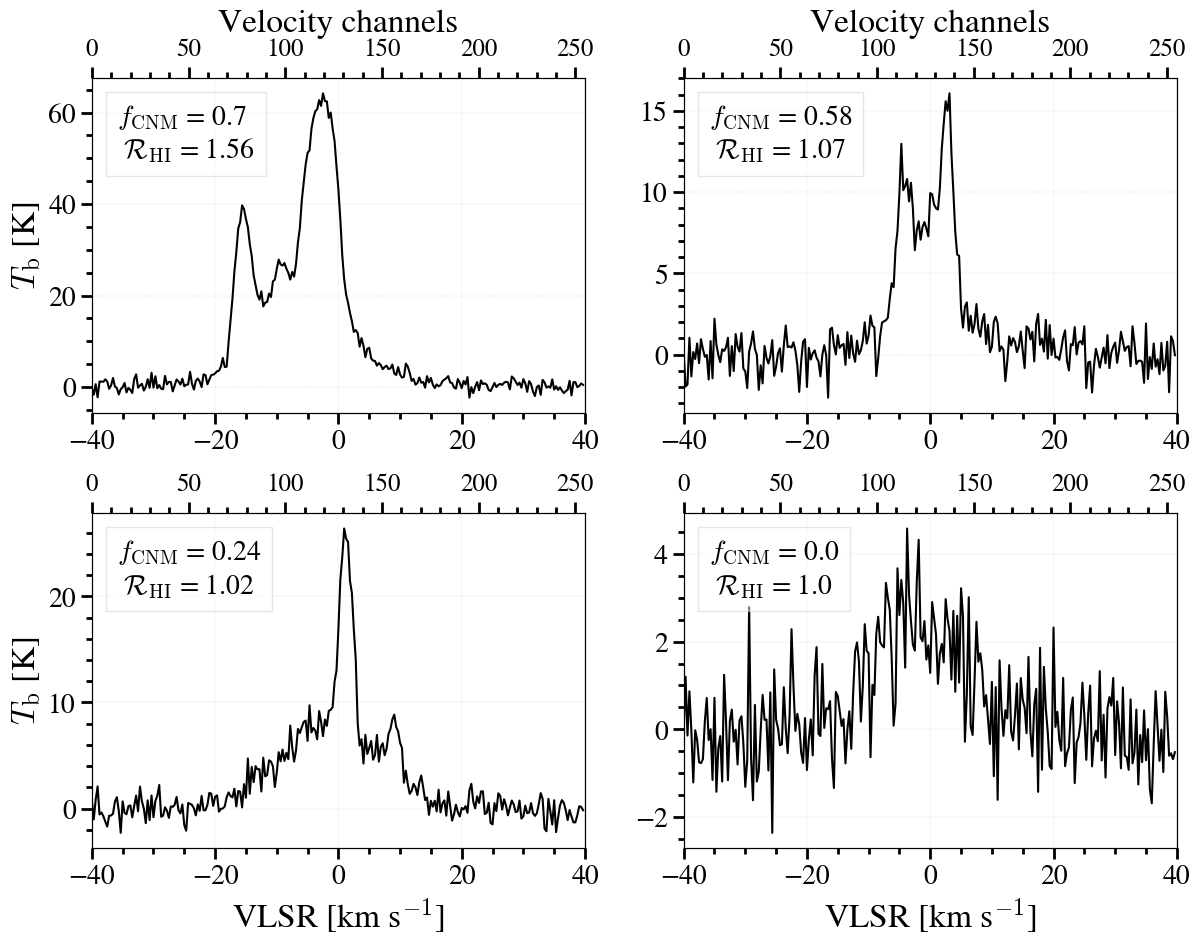

In [ ]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(221)


i = 405
j = 25
fcnm_i = round(fcnm_data5[j, i], 2)
rhi_i = round(rhi_data5[j, i], 2)

ax.plot(v, cube5[:, j, i], 'k-', label=r'$f_\mathrm{CNM}$ = '+str(fcnm_i)+'\n $\mathcal{R}_\mathrm{HI}$ = '+str(rhi_i))

# plt.title('Training set')
# ax.set_xlabel('VLSR [km s$^{-1}$]', fontsize=18)
ax.set_ylabel('$T_\mathrm{b}$ [K]', fontsize=24)



# Add axes labels
ax.minorticks_on()
ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=4)

# ax.tick_params(axis='both', which='both', length=6, width=1, labelsize=20)
ax.set_xlim(-40, 40.)

ax.grid(True, linestyle='--', linewidth=0.25, color='lightgray', zorder=-10)
leg = ax.legend(loc='upper left', fancybox=False, framealpha=0.5, labelcolor='k', fontsize=20, handletextpad=-2.0)
[item.set_visible(False) for item in leg.legend_handles]


# Create a secondary x-axis on top
ax2 = ax.twiny()

# Plot additional data on the secondary x-axis
# ax2.plot(v, cube3[:, j, i], color='red', label='Secondary Axis - cos(x)')
ploti, = ax2.plot(cube5[:, j, i], color='k', label='')
ploti.set_visible(False)


ax2.set_xlabel('Velocity channels', fontsize=24)
# ax2.set_ylabel('cos(x)', color='red')
# ax2.tick_params('y', colors='red')


# Add axes labels
ax2.minorticks_on()
ax2.tick_params(axis='x', labelsize=18, pad=4)
ax2.tick_params(axis='y', labelsize=18)
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=8)
ax2.tick_params(which='minor', length=4)
ax2.set_xlim(0,255)

## Color bar
# cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.025, pad=0.006, aspect=35)
# cbar.ax.set_ylabel('$f^\mathrm{gt}_\mathrm{CNM}$', rotation=90, labelpad=5., fontsize=18)
# cbar.ax.tick_params(labelsize=16)







ax = fig.add_subplot(222)

i = 150
j = 460
fcnm_i = round(fcnm_data4[j, i], 2)
rhi_i = round(rhi_data4[j, i], 2)

# Plot
ax.plot(v, cube4[:, j, i], 'k-', label=r'$f_\mathrm{CNM}$ = '+str(fcnm_i)+'\n $\mathcal{R}_\mathrm{HI}$ = '+str(rhi_i))

# plt.title('Training set')
# ax.set_xlabel('Velocity channels', fontsize=18)
# ax.set_ylabel('$T_\mathrm{B}$ [K]', fontsize=22)



# Add axes labels
ax.minorticks_on()
ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=4)

# ax.tick_params(axis='both', which='both', length=6, width=1, labelsize=20)
ax.set_xlim(-40, 40.)

ax.grid(True, linestyle='--', linewidth=0.25, color='lightgray', zorder=-10)
leg = ax.legend(loc='upper left', fancybox=False, framealpha=0.5, labelcolor='k', fontsize=20, handletextpad=-2.0)
[item.set_visible(False) for item in leg.legend_handles]


# Create a secondary x-axis on top
ax2 = ax.twiny()

# Plot additional data on the secondary x-axis
# ax2.plot(v, cube3[:, j, i], color='red', label='Secondary Axis - cos(x)')
ploti, = ax2.plot(cube4[:, j, i], color='k', label='')
ploti.set_visible(False)


ax2.set_xlabel('Velocity channels', fontsize=24)
# ax2.set_ylabel('cos(x)', color='red')
# ax2.tick_params('y', colors='red')


# Add axes labels
ax2.minorticks_on()
ax2.tick_params(axis='x', labelsize=18, pad=4)
ax2.tick_params(axis='y', labelsize=18)
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=8)
ax2.tick_params(which='minor', length=4)
ax2.set_xlim(0,255)







# ========
ax = fig.add_subplot(223)

i = 232
j = 200
fcnm_i = round(fcnm_data5[j, i], 2)
rhi_i = round(rhi_data5[j, i], 2)

# Plot
ax.plot(v, cube5[:, j, i], 'k-', label=r'$f_\mathrm{CNM}$ = '+str(fcnm_i)+'\n $\mathcal{R}_\mathrm{HI}$ = '+str(rhi_i))

ax.set_ylabel('$T_\mathrm{b}$ [K]', fontsize=24)
ax.set_xlabel('VLSR [km s$^{-1}$]', fontsize=24)

# Add axes labels
ax.minorticks_on()
ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=4)

# ax.tick_params(axis='both', which='both', length=6, width=1, labelsize=20)
ax.set_xlim(-40, 40.)



ax.grid(True, linestyle='--', linewidth=0.25, color='lightgray', zorder=-10)
leg = ax.legend(loc='upper left', fancybox=False, framealpha=0.5, labelcolor='k', fontsize=20, handletextpad=-2.0)
[item.set_visible(False) for item in leg.legend_handles]


# Create a secondary x-axis on top
ax2 = ax.twiny()

# Plot additional data on the secondary x-axis
# ax2.plot(v, cube3[:, j, i], color='red', label='Secondary Axis - cos(x)')
ploti, = ax2.plot(cube5[:, j, i], color='k', label='')
ploti.set_visible(False)


# ax2.set_xlabel('Velocity channels', fontsize=18)
# ax2.set_ylabel('cos(x)', color='red')
# ax2.tick_params('y', colors='red')


# Add axes labels
ax2.minorticks_on()
ax2.tick_params(axis='x', labelsize=18, pad=4)
ax2.tick_params(axis='y', labelsize=18)
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=8)
ax2.tick_params(which='minor', length=4)
ax2.set_xlim(0,255)






ax = fig.add_subplot(224)

i = 300
j = 300
fcnm_i = round(fcnm_data2[j, i], 2)
rhi_i = round(rhi_data2[j, i], 2)

# Plot
ax.plot(v, cube2[:, j, i], 'k-', label=r'$f_\mathrm{CNM}$ = '+str(fcnm_i)+'\n $\mathcal{R}_\mathrm{HI}$ = '+str(rhi_i))

# plt.title('Training set')
ax.set_xlabel('VLSR [km s$^{-1}$]', fontsize=24)
# ax.set_ylabel('$T_\mathrm{B}$ [K]', fontsize=22)



# Add axes labels
ax.minorticks_on()
ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=4)

# ax.tick_params(axis='both', which='both', length=6, width=1, labelsize=20)
ax.set_xlim(-40., 40.)

ax.grid(True, linestyle='--', linewidth=0.25, color='lightgray', zorder=-10)
leg = ax.legend(loc='upper left', fancybox=False, framealpha=0.5, labelcolor='k', fontsize=20, handletextpad=-2.0)
[item.set_visible(False) for item in leg.legend_handles]


# Create a secondary x-axis on top
ax2 = ax.twiny()

# Plot additional data on the secondary x-axis
# ax2.plot(v, cube3[:, j, i], color='red', label='Secondary Axis - cos(x)')
ploti, = ax2.plot(cube2[:, j, i], color='k', label='')
ploti.set_visible(False)


# ax2.set_xlabel('Velocity channels', fontsize=18)
# ax2.set_ylabel('cos(x)', color='red')
# ax2.tick_params('y', colors='red')


# Add axes labels
ax2.minorticks_on()
ax2.tick_params(axis='x', labelsize=18, pad=4)
ax2.tick_params(axis='y', labelsize=18)
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=8)
ax2.tick_params(which='minor', length=4)
ax2.set_xlim(0,255)




# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.2,
                    hspace=0.3
                    )

# plt.tight_layout()
plt.show()
plt.close()

# Histograms of $f_\text{CNM}$ and $R_\text{HI}$

In [ ]:
fcnm_flat_data1 = fcnm_data1.flatten()
fcnm_flat_data2 = fcnm_data2.flatten()
fcnm_flat_data3 = fcnm_data3.flatten()
fcnm_flat_data4 = fcnm_data4.flatten()
fcnm_flat_data5 = fcnm_data5.flatten()

rhi_flat_data1 = rhi_data1.flatten()
rhi_flat_data2 = rhi_data2.flatten()
rhi_flat_data3 = rhi_data3.flatten()
rhi_flat_data4 = rhi_data4.flatten()
rhi_flat_data5 = rhi_data5.flatten()

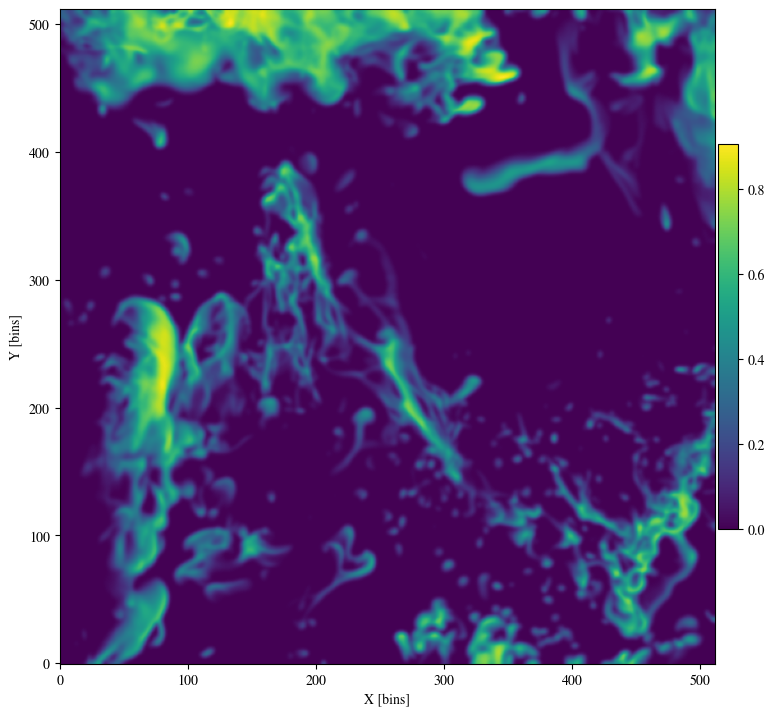

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(fcnm_data4, origin='lower', cmap='viridis')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('', size=16)

# plt.title('')
plt.xlabel('X [bins]')
plt.ylabel('Y [bins]')
plt.show()

In [ ]:
bighicat_fcnm = bighicat_fcnm[~np.isnan(bighicat_fcnm)]
bighicat_fcnm.shape

(269,)

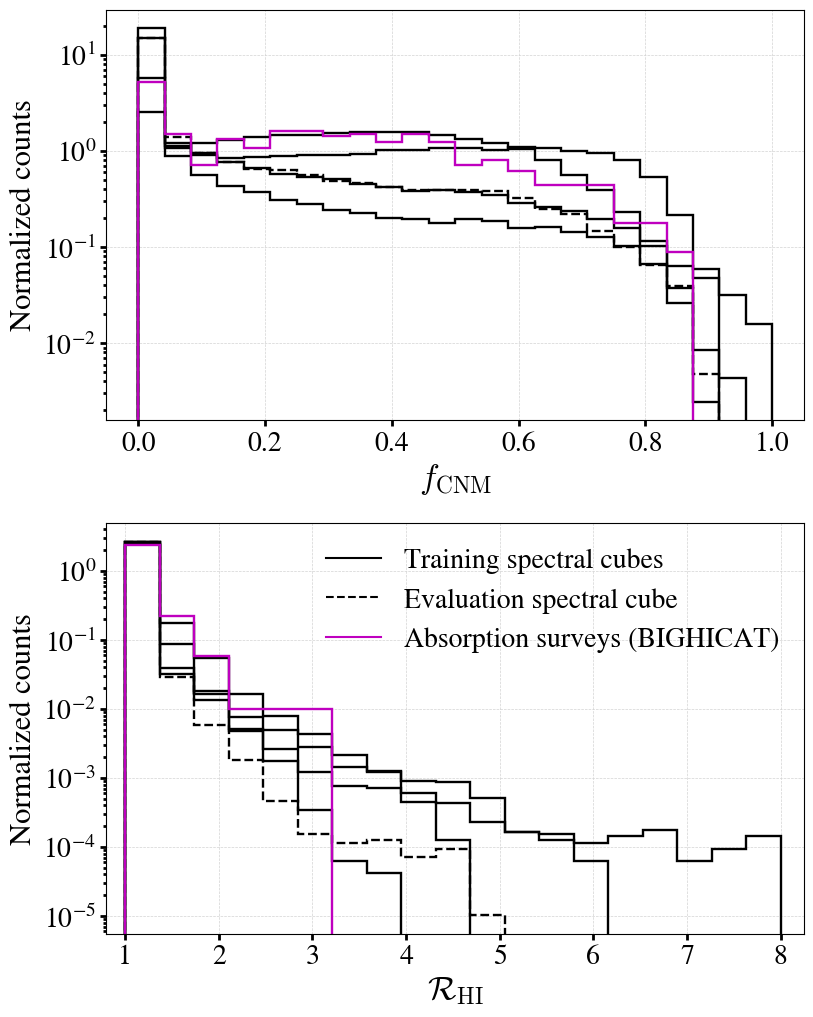

In [ ]:
fig = plt.figure(figsize=(9,12))


# Plot:
ax = fig.add_subplot(211) # projection=w

lw = 1.7
ls = '-'

nbins = 25
ax.hist(fcnm_flat_data1, bins=np.linspace(0., 1., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls=ls, lw=lw,
         label='')

ax.hist(fcnm_flat_data2, bins=np.linspace(0., 1., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls=ls, lw=lw,
         label='')

ax.hist(fcnm_flat_data4, bins=np.linspace(0., 1., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls='--', lw=lw,
         label='')

ax.hist(fcnm_flat_data3, bins=np.linspace(0., 1., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls=ls, lw=lw,
         label='')

ax.hist(fcnm_flat_data5, bins=np.linspace(0., 1., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls=ls, lw=lw,
         label='')

plt.hist(bighicat_fcnm, bins=np.linspace(0., 1., nbins),
         density=True, color='m', histtype='step', alpha=1.,
         ls='-', lw=lw, label='')

plt.yscale('log')


# Add axes labels
# ax.set_xlabel(r"Galactic longitude [$^\mathrm{o}$]", fontsize=12)
# ax.set_ylabel(r' ', fontsize=12)
ax.set_xlabel(r'$f_\mathrm{CNM}$', fontsize=24)
ax.set_ylabel(r'Normalized counts', fontsize=22)


# ax.invert_yaxis()
# ax.invert_xaxis()


ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)






# Plot:
ax = fig.add_subplot(212)


ls = '-'
nbins = 20

ax.hist(rhi_flat_data1, bins=np.linspace(1., 8., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls=ls, lw=lw,
         label='')

ax.hist(rhi_flat_data2, bins=np.linspace(1., 8., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls=ls, lw=lw,
         label='')

ax.hist(rhi_flat_data4, bins=np.linspace(1., 8., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls='--', lw=lw,
         label='')

ax.hist(rhi_flat_data3, bins=np.linspace(1., 8., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls=ls, lw=lw,
         label='')

ax.hist(rhi_flat_data5, bins=np.linspace(1., 8., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls=ls, lw=lw,
         label='')


ax.hist(bighicat_rhi, bins=np.linspace(1., 8., nbins),
         density=True, color='m', histtype='step',
         alpha=1., ls='-', lw=lw,
         label='')


ploti, = ax.plot([], [], 'k-', label='Training spectral cubes')
ploti.set_visible(True)

ploti, = ax.plot([], [], 'k--', label='Evaluation spectral cube')
ploti.set_visible(True)

ploti, = ax.plot([], [], 'm-', label='Absorption surveys (BIGHICAT)')
ploti.set_visible(True)


plt.yscale('log')


ax.set_xlabel(r'$\mathcal{R}_\mathrm{HI}$', fontsize=24)
ax.set_ylabel(r'Normalized counts', fontsize=22)


ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

ax.set_xlim(0.8, 8.25)

ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax.legend(loc='upper right', fancybox=False, framealpha=0.0, labelcolor='k', fontsize=20)







# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.2,
                    hspace=0.25
                    )



plt.show()